<a href="https://colab.research.google.com/github/lanhhv84/CVND_Exercises/blob/master/YOLO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www.cyberailab.com/home/a-closer-look-at-yolov3

### Import

In [1]:
from google.colab import drive
drive.mount('/content/drive')

from pathlib import PosixPath

root = PosixPath('/content/drive/My Drive/DS/')
path = root/'yolo'
train_images_path = path/'WIDER_train/images'
val_images_path = path/'WIDER_val/images'
train_save_path = path/'save.bin'
val_save_path = path/'val_save.bin'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import sys

sys.path.append(str(root/'lib'))

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.nn.modules.upsampling import Upsample
import cv2
from PIL import Image
from tqdm.autonotebook import tqdm
import matplotlib.pyplot  as plt
from torch.utils.data import Dataset, DataLoader
from os.path import isfile
from joblib import dump, load
from functools import partial
from torchvision import transforms
from custom_module import CustomModule

/usr/local/lib/python3.6/dist-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [0]:
NBOXES = 3
N_CLASSES = 0
FEATURES = NBOXES*(5 + N_CLASSES)

In [0]:
TX = 0
TY = 1
TW = 2
TH = 3
CONF = 4
bs = 4


IMAGE_GRID = 26
IMAGE_SIZE = 416
# label = [bouding box, (5), 26, 26]
BOX_SIZDE = IMAGE_SIZE / IMAGE_GRID
IMG_SIZE = 416
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

LOSS_REDUCTION = 'sum'

### Darknet

- There are objects of different sizes on the images $\rightarrow$  It is desirable for the network to detect all of them
-  As the network goes deeper, its feature map gets smaller $\rightarrow$ the deeper it goes, the harder it is to detect smaller objects
- Intuitively, it is better to detect the objects at different feature maps before small objects end up disappearing

- However, the features are not absolutely relevant  at different depth 
- With network depth increasing $\rightarrow$ the features change from low-level features (edges, colors, rough 2D positions. etc) to high-level features (semantic-meaningful information: dog, cat, car. etc) with depth increasing
- Making predictions on feature maps at different depth does sound it is able to do detection for multi-scale objects, but actually it is not as accurate as expected

![](https://static.wixstatic.com/media/4b2724_c63846f57e8c41dd8f40720125fa3f63~mv2.png/v1/fill/w_740,h_455,al_c,q_90,usm_0.66_1.00_0.01/4b2724_c63846f57e8c41dd8f40720125fa3f63~mv2.webp)

In [0]:
class Darknet211(nn.Module):
    
    def __init__(self, in_channels):
        super(Darknet211, self).__init__()
        out_channels = int(in_channels * 2)
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(in_channels=out_channels, out_channels=in_channels, kernel_size=1, stride=1, padding=0)
        self.conv3 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1)
        
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(in_channels)
        self.bn3 = nn.BatchNorm2d(out_channels)
        
        self.leaky = nn.LeakyReLU(0.1)
        
    def forward(self, data):
        out1 = self.leaky(self.bn1(self.conv1(data)))
        out2 = self.leaky(self.bn2(self.conv2(out1)))
        out3 = self.leaky(self.bn3(self.conv3(out2)))
        return out3 + out1
    
        
    
class Darknet11(nn.Module):
    
    def __init__(self, in_channels):
        super(Darknet11, self).__init__()
        hidden_channels = int(in_channels // 2)
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=hidden_channels, kernel_size=1, stride=1, padding=0)
        self.conv2 = nn.Conv2d(in_channels=hidden_channels, out_channels=in_channels, kernel_size=3, stride=1, padding=1)
        
        self.bn1= nn.BatchNorm2d(hidden_channels)
        self.bn2= nn.BatchNorm2d(in_channels)
        
        self.leaky = nn.LeakyReLU(0.1)
        
    def forward(self, data, prev_out):
        out = self.bn1(self.conv1(data))
        out = self.bn2(self.conv2(out))
        return out + prev_out

    
class Darknet211_i(nn.Module):
    
    def __init__(self, in_channels, n_layers=7):
        super(Darknet211_i, self).__init__()
        hidden_channels = int(in_channels * 2)
        self.conv1 = Darknet211(in_channels=in_channels) # => hidden_channels
        layers = []
        for _ in range(n_layers):
            layers.append(Darknet11(in_channels=hidden_channels))
        self.conv2 = nn.ModuleList(layers)
        
    def forward(self, data):
        out = self.conv1(data)
        for layer in self.conv2:
            out = layer(out, out)
        return out
        
class Darknet71(nn.Module):
    
    def __init__(self, in_channels, exp_channels):
        super(Darknet71, self).__init__()
        layers = [nn.Conv2d(in_channels=in_channels, out_channels=exp_channels, kernel_size=1, stride=1, padding=0)]
        bns = [nn.BatchNorm2d(exp_channels)]
        
        for i in range(5):
            if i % 2 == 0:
                layers.append(nn.Conv2d(in_channels=exp_channels, out_channels=exp_channels*2, kernel_size=3, stride=1, padding=1))
                bns.append(nn.BatchNorm2d(exp_channels*2))
            else:
                layers.append(nn.Conv2d(in_channels=exp_channels*2, out_channels=exp_channels, kernel_size=1, stride=1, padding=0))
                bns.append(nn.BatchNorm2d(exp_channels))
                
        layers.append(nn.Conv2d(in_channels=exp_channels*2, out_channels=FEATURES, kernel_size=1, stride=1, padding=0))
        bns.append(nn.BatchNorm2d(FEATURES))
        self.layers = nn.ModuleList(layers)
        self.bns = nn.ModuleList(bns)
    
    def forward(self, data):
        out = data 
        for layer, bn in zip(self.layers[:-1], self.bns[:-1]):
            out = layer(out)
            out = bn(out)
        return out, self.bns[-1](self.layers[-1](out))
        
        

class Darknet(CustomModule):
    
    def __init__(self):
        super(Darknet, self).__init__()
        # Block 1
        self.block1_conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.block1_bn1 = nn.BatchNorm2d(32)
        self.block1_conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.block1_bn2 = nn.BatchNorm2d(64)
        self.block1_conv3 = nn.Conv2d(64, 32, kernel_size=1, stride=1, padding=0)
        self.block1_bn3 = nn.BatchNorm2d(32)
        self.block1_conv4 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.block1_bn4 = nn.BatchNorm2d(64)
        self.leaky = nn.LeakyReLU(0.1)
        # block 2-23
        units = [64*(2**i) for i in range(4)]
        li = [1, 7, 7, 3]
        layers = [Darknet211_i(unit, l) for unit, l in zip(units, li)]
        self.block2_23 = nn.ModuleList(layers)
        # block 24
        self.block24 = Darknet71(1024, 512)
        # block 25 conv 256x1x1 + upsample
        self.block25_conv = nn.Conv2d(1024, 256, 1, 1, 0)
        self.bn25 = nn.BatchNorm2d(256)
        self.block25_upsample = nn.Upsample(scale_factor=2, align_corners=False, mode='bilinear')
        # block 26
        self.block26 = Darknet71(768, 256)
        # block 27
        self.block27_conv = nn.Conv2d(512, 128, 1, 1, 0)
        self.bn27 = nn.BatchNorm2d(128)
        self.block27_upsample = nn.Upsample(scale_factor=2, align_corners=False, mode='bilinear')
        # block 28
        self.block28 = Darknet71(384, 128)
        
        
    def forward(self, data):
        out = data
        out0 = self.leaky(self.block1_bn1(self.block1_conv1(out)))
        out1 = self.leaky(self.block1_bn2(self.block1_conv2(out0)))
        out2 = self.leaky(self.block1_bn3(self.block1_conv3(out1)))
        out3 = self.leaky(self.block1_bn4(self.block1_conv4(out2)))
        out = out3 + out1
        b1_hidden = None # 256, 52, 52
        
        for layer in self.block2_23[:-1]:
            out = layer(out)
            if list(out.shape[1:]) == [256, 52, 52]:
                b1_hidden = out
        cat_out = out # 512, 26, 26
        out = self.block2_23[-1](out) # 1024, 13, 13
        b2 = self.leaky(self.bn25(self.block25_conv(out)))
        
        b2 = self.block25_upsample(b2) # 256, 26, 26
        b2 = torch.cat([cat_out, b2], dim=1) # 768, 26, 26
        b2_hidden, b2 = self.block26(b2) # (512, 26, 26) (255, 26, 26)
        # branch 3
        b3 = self.block24(out) # 255, 13, 13
        
        # branch 1
        b1 = self.leaky(self.bn27(self.block27_conv(b2_hidden)))
        b1 = self.block27_upsample(b1) # 128, 52, 52
        b1 = torch.cat([b1_hidden, b1], dim=1) # 384, 52, 52
        b1 = self.block28(b1)
        bs = b2.shape[0]
        
        # Prediction
        b1, b2, b3 = [x.view(bs, NBOXES, FEATURES // NBOXES, x.shape[-1], x.shape[-1]) for x in [b1[-1], b2, b3[-1]]]
        branches = [b1, b2, b3]
        for i in range(len(branches)):
            branches[i][:, :, TX, :, :] = torch.sigmoid(branches[i][:, :, TX, :, :])
            branches[i][:, :, TY, :, :] = torch.sigmoid(branches[i][:, :, TY, :, :])
            branches[i][:, :, CONF, :, :] = torch.sigmoid(branches[i][:, :, CONF, :, :])
        # [8, 3, 5, 52, 52]
        
        for b in branches:
                for x in range(b.shape[-1]):
                    for y in range(b.shape[-1]):
                        b[:, :, TX, x, y] = b[:, :, TX, x, y]
                        b[:, :, TY, x, y] = b[:, :, TY, x, y]
                b[:, :, TW, :, :] = torch.exp(b[:, :, TW, :, :])*(IMG_SIZE / b.shape[-1])
                b[:, :, TH, :, :] = torch.exp(b[:, :, TH, :, :])*(IMG_SIZE / b.shape[-1])
                        
        return b1, b2, b3
    
    
        nn.Conv2d()
        
# output: (255, 52, 52), (255, 26, 26), (255, 13, 13)

### Loss

In [0]:
def regression_loss(predicted, truth, mse_loss):
    pred = predicted[:, :, :4, :, :]
    pred = pred.view(-1, 4, pred.shape[-1]*pred.shape[-2]).permute(0, 2, 1)
    tr = truth[:, :, :4, :, :]
    tr = tr.view(-1, 4, tr.shape[-1]*tr.shape[-2]).permute(0, 2, 1)
    tr = tr.contiguous().view(-1, tr.shape[-1])
    pred = pred.contiguous().view(-1, pred.shape[-1])
    return mse_loss(tr, pred)


def prediction_loss(predicted, truth, bce_loss, alpha, reduction='mean'):
    pred = predicted[:, :, CONF, :, :]
    tr = truth[:, :, CONF, :, :]
    pred = pred.contiguous().view(-1)
    tr = tr.contiguous().view(-1)
    loss = -tr*torch.log(pred) - alpha*(1-tr)*torch.log(1 - pred)
    if reduction == 'mean':
        loss = torch.mean(loss)
    else:
        loss = torch.sum(loss)
    return loss
    
    
    

### Data

In [0]:
# !rm '/content/drive/My Drive/DS/yolo/save.bin'

In [0]:
# !unzip '/content/drive/My Drive/DS/yolo/WIDER_train.zip' -d '/content/drive/My Drive/DS/yolo/' > /content/log.txt
# !unzip '/content/drive/My Drive/DS/yolo/WIDER_val.zip' -d '/content/drive/My Drive/DS/yolo/' > /content/log.txt
# !unzip '/content/drive/My Drive/DS/yolo/wider_face_split.zip' -d '/content/drive/My Drive/DS/yolo/' > /content/log.txt

In [0]:
import PIL

class WIDERDS(Dataset):
    
    def __init__(self, anno_path, image_path, save_path):
        if isfile(save_path):
            data = load(save_path)
        else:
            data = WIDERDS.load(anno_path=anno_path, image_path=image_path)
            dump(data, save_path)
        self.data = data
        self.image_path = image_path
        self.tfms = None
    
    @staticmethod
    def load(anno_path, image_path):
        
        with open(anno_path) as f:
            data = f.readlines()
        index = 0
        bbxs = []
        while index < len(data):
            file = data[index]
            annos = []
            number = data[index + 1]
            index = index + 2
            for _ in range(int(number)):
                annos.append(data[index])
                index = index + 1
            if int(number) == 0:
                index = index + 1
            bbxs.append([file, annos])
        data = [[x[:-1], [y[:-1] for y in z]] for x, z in bbxs]
        
        for i in range(len(data)):
            boxes = data[i][1]
            for b in range(len(boxes)):
                boxes[b] = [int(x) for x in boxes[b].split(' ')[:4]]
                
                
        labels = []
        for file, boxes in tqdm(data):
            label = torch.zeros(NBOXES, FEATURES // NBOXES, IMAGE_GRID, IMAGE_GRID)
            image = Image.open(image_path/file)
            image = np.asarray(image)
            h, w = image.shape[:2]
            w_scale = w / IMAGE_GRID
            h_scale = h / IMAGE_GRID
            for box in boxes:
                tx, ty, tw, th = box[TX], box[TY], box[TW], box[TH]
                tw = tw / 2

                th = th / 2
                cx, cy = tx + tw, ty + th
                tw = tw / w
                th = th / h
                tw = tw / w_scale
                th = th / h_scale
                tw_box = int(tw*IMAGE_GRID)
                th_box = int(th*IMAGE_GRID)
                overlap = False
                for i in range(3):
                    if all([label[i, t, th_box, tw_box] == 0 for t in range(5)]):
                        label[i, TX, th_box, tw_box] = tx
                        label[i, TY, th_box, tw_box] = ty
                        label[i, TW, th_box, tw_box] = tw
                        label[i, TH, th_box, tw_box] = th
                        label[i, CONF, th_box, tw_box] = 1
                    else:
                        overlap = True
            if not overlap:
                labels.append([file, label])
                
        return labels
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        file, label = self.data[idx]
        image = PIL.Image.open(str(self.image_path/file))
        if self.tfms:
            image = self.tfms(image)
        return image, label
    
    def transform(self, tfms):
        self.tfms = tfms
        return self
        

In [0]:
%matplotlib inline

In [0]:
train_bbx_path = path/'wider_face_split/wider_face_train_bbx_gt.txt'
val_bbx_path = path/'wider_face_split/wider_face_val_bbx_gt.txt'

In [0]:
train_ds = WIDERDS(train_bbx_path, train_images_path, train_save_path)
val_ds = WIDERDS(val_bbx_path, val_images_path, val_save_path)

In [0]:

def collate(data, path, tfms, device):
    files = [x[0] for x in data]
    labels = [x[1] for x in data]
    files = [Image.open(path/x) for x in files]
    if tfms:
        files = [tfms(x) for x in files]
    else:
        files = [ToTensor()(x) for x in files]
    images = torch.cat([x[None] for x in files], dim=0).to(device)
    labels = torch.cat([x[None] for x in labels], dim=0).to(device)
    return images, labels

train_tfms = transforms.Compose([transforms.Resize([416, 416]), transforms.ToTensor()])
train_collate = partial(collate, path=train_images_path, tfms=train_tfms, device=device)
test_tfms = train_tfms
val_collate = partial(collate, path=val_images_path, tfms=test_tfms, device=device)


In [0]:
# train_loader = DataLoader(train_ds, bs, True, collate_fn=train_collate)
# val_loader = DataLoader(val_ds, bs, True, collate_fn=val_collate)

In [0]:
from fastai.vision import *

In [0]:
data = DataBunch.create(train_ds=train_ds, valid_ds=val_ds, bs=bs, val_bs=bs, device=device)

In [0]:
data_transforms = get_transforms(do_flip=True, flip_vert=True, max_rotate=10.0, max_zoom=1, max_lighting=0, max_warp=0, p_affine=0.75, p_lighting=0.75)

In [0]:
data = data.transform(data_transforms)

In [61]:
data.train_ds[0][0].show()

AttributeError: ignored

AttributeError: ignored

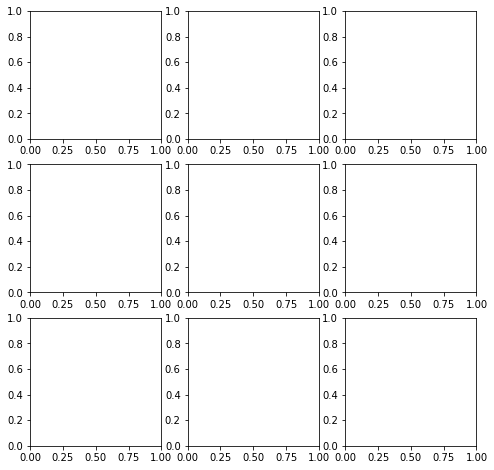

In [24]:
def _plot(i,j,ax): data.train_ds[i][j].show(ax)
plot_multi(_plot, 3, 3, figsize=(8,8))

### Feed

In [0]:
net = Darknet().to(device)

In [0]:
class Item():
    
    def item(self):
        return 1

In [0]:
mse = nn.MSELoss(reduction=LOSS_REDUCTION)
bce = nn.BCELoss(reduction=LOSS_REDUCTION)
n_train_batches = len(train_ds) // bs + 1
n_val_batches = len(val_ds) // bs + 1
loss = []
pstep = 20
spath = path/'weight.bin'
ap = 1
crit = lambda p, t: regression_loss(p[1], t, mse) + prediction_loss(p[1], t, bce, ap, LOSS_REDUCTION)
ifilter = lambda x: [x[0]]
ofilter = lambda y: y[1]
metric = lambda x, y: Item()
opt = torch.optim.Adam(net.parameters())

In [16]:
net.train_loader(train_loader, n_train_batches, loss, pstep, spath, crit, ifilter, ofilter, metric, num_test_batches=n_val_batches, optimizer=opt)

Training Epoch 1 [0.00%] Loss: 19056040.0
Training Epoch 1 [6.82%] Loss: 6489307.5

KeyboardInterrupt: ignored

In [0]:
x, y = next(iter(train_loader))

In [0]:
x.shape

In [0]:
!ls '/content/drive/My Drive/DS/yolo/WIDER_train/images/48--Parachutist_Paratrooper'

tensor(0.6927, device='cuda:0', grad_fn=<MeanBackward0>)

In [0]:
rimage = cv2.rectangle(image, (x,y), (x+w,y+h), (255,0,0), 3)

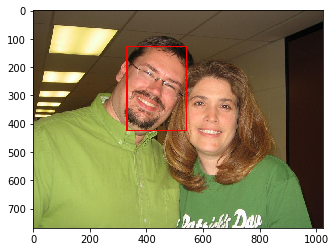

In [0]:
plt.imshow(rimage)